# Summary 3/19/20
This is a short walk-through of our current fast implementation of the btg program emphasizing workflow and data-analysis.

As of 3/19, the code adheres to most of the points outlined in the Latex BTG document started by Eric. Namely, it
- supports covariates
- stably computes weights $w(\theta_i, \lambda_j) \propto |\Sigma_\theta|^{-1/2} \tilde{q}^{-\frac{n-p}{2}} \text{jac}(z)$ by working with exponents and shifting largest exponent to $0$
- uses a quadrature rule on $\theta$ and $\lambda$
- Normalizes weights to get proper distribution: $ w(\theta_i, \lambda_j) = \frac{w(\theta_i) w(\lambda_j) p(y | \theta_i, \lambda_j)}
                                    {\sum_{i,j} w(\theta_i) w(\lambda_j) p(y | \theta_i, \lambda_j)}$
- takes advantage of built-in Julia T-dist CDF and PDF functions to compute Bayesian predictive PDF and CDF 
- includes documentation for each function
- stores and updates set of Cholesky factorizations

In addition it also 
- supports both Gaussian and Gauss-Turan quadrature for $\theta$ 
- includes derivatives for $\frac{\partial}{\partial z_{0}}\phi(z_0|z)$ for faster root finding and $\frac{\partial}{\partial s} \Phi(z_0|z;s)$ for solving the LCB-BO optimization problem, where $\Phi$ and $\phi$ are the CDF and PDFs of the Bayesian predictive distribution.
- uses bisection to find symmetric 95% credible interval about the median with Golden section search 
- doesn't suffer from improperness of distribution. It seems like CDF is always $\approx 1$ at sufficiently large number



### TODO: 
- Solve optimization problem for LCB-BO to determine next sampling point
       
$$\text{min}_u \;\text{s.t.}\;G(u;s)=0.25$$
by considering Lagrangian
$$\mathcal{L}(u, \lambda) = u+\lambda[G(u;s)-0.25]$$

- Apply Gaussian process regression on datasets (creep, abalone, ailerons) + comparison with warped GP
- Finish confidence-interval/mean/median-finding codes, possibly accelerate with derivatives
- Monte-Carlo quadrature for really high dimensions??
- Integrate sparsegrids.jl into package to do higher dimensional quadrature
- Scaling issues
- modify package to take new training points, i.e. extend the cholesky system
- multiple lengthscale in current codebase



## 1) Problem Setup

In [1]:
include("../startup.jl")

  Updating registry at `C:\Users\Albert Huang\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %.3 % ]  96.2 % Resolving package versions...
 Installed PDMats ──────── v0.9.12
 Installed Zygote ──────── v0.4.10
 Installed Optim ───────── v0.20.4
 Installed Distributions ─ v0.23.0
  Updating `C:\Users\Albert Huang\Desktop\fix\btg\BayesTransformedGaussian\Project.toml`
  [336ed68f] + CSV v0.5.26
  [667455a9] + Cubature v1.4.1
  [a93c6f00] + DataFrames v0.20.2
  [b4f34e82] + Distances v0.8.2
  [31c24e10] + Distributions v0.23.0
  [e30172f5] + Documenter v0.24.6
  [442a2c76] + FastGaussQuadrature v0.4.2
  [10e44e05] + MATLAB v0.7.3
  [429524aa] + Optim v0.20.4
  [90014a1f] + PDMats v0.9.12
  [91a5bcdd] + Plots v0.29.8
  [f27b6e38] + Polynomials v0.6.1
  [d330b81b] + PyPlot v2.8.2
  [3cdcf5f2] + RecipesBase v0.8.0
  [189a3867] + Reexport v0.2.0
  [6e75b9c4] + ScikitLearnBase v0.5.

  [6462fe0b] + Sockets 
  [2f01184e] + SparseArrays 
  [10745b16] + Statistics 
  [4607b0f0] + SuiteSparse 
  [8dfed614] + Test 
  [cf7118a7] + UUIDs 
  [4ec0a83e] + Unicode 
 Resolving package versions...
  Updating `C:\Users\Albert Huang\Desktop\fix\btg\BayesTransformedGaussian\Project.toml`
 [no changes]
  Updating `C:\Users\Albert Huang\Desktop\fix\btg\BayesTransformedGaussian\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\Albert Huang\Desktop\fix\btg\BayesTransformedGaussian\Project.toml`
 [no changes]
  Updating `C:\Users\Albert Huang\Desktop\fix\btg\BayesTransformedGaussian\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\Albert Huang\Desktop\fix\btg\BayesTransformedGaussian\Project.toml`
 [no changes]
  Updating `C:\Users\Albert Huang\Desktop\fix\btg\BayesTransformedGaussian\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\Albert Huang\Desktop\fix\btg\BayesTransformedGaussian\Proje

In [1]:
include("../src/model.jl")
include("../src/transforms.jl")
include("../src/tools/plotting.jl")
include("../src/validation/validate.jl")
using DataFrames
using CSV
using Plots

LoadError: LoadError: syntax: missing comma or ) in argument list
in expression starting at /Users/zhuxinran/projects/BTG/btg/BayesTransformedGaussian/src/computation/derivatives.jl:536

Next we load the Abalone dataset, take a subset, and split it into train and test sets. We preprocess the dataset by squashing the data labels into the range $[0, 1]$. 

As per conventions in the paper, $s$ is the observation locations, $s_0$ is the prediction location, $X$ is the matrix of covariates for observed locations (where value/label is known), $X_0$ is matrix of covariates for prediction locations, and $z$ is vector of values/labels corresponding to observed locations $s$.  

In [3]:
df = DataFrame(CSV.File("../src/datasets/abalone.csv"))
data = convert(Matrix, df[:,2:8]) #length, diameter, height, whole weight, shucked weight, viscera weight, shell weight
target = convert(Array, df[:, 9]) #age
# target = target/maximum(target) #normalization 

#pick training points
ind = 1:30
s = data[ind, :]

#choose a subset of variables to be regressors for the mean
X = data[ind, 1:3] 
z = float(target[ind])
zmax = maximum(z)
z = z./zmax# normalizate the training data

#prior marginals are assumed constant for now
pλ = x -> 1  #p(λ)
pθ = x -> 1 #p(θ)
dpθ = x -> 0 #p'(λ)
dpθ2 = x -> 0 #p'(θ)

#define ranges for theta and lambda, which we will be integrating over
range_theta = [10.0, 100.0]
range_lambda = [-1.0, 1.0]

i = 240 #random index, where we will make prediction
s0 = data[i:i,:] #covariates and coordinates
X0  = data[i:i, 1:3]

train = trainingData(s, X, z) #a trainingData object contains s, X, and z
test = testingData(s0, X0) #a testingData object is missing z_0, the latent values at locations s_0

testingData{Array{Float64,2}}([0.565 0.425 … 0.2185 0.275], [0.565 0.425 0.16])

## 2) Computing the Bayesian Predictive Distribution
The cumulative and probability density functions for the $240$th data-point, conditioned on $30$ observed datapoints, are plotted below. Both Gauss quadrature and Turan quadrature use $12$ quadrature nodes. The plots are essentially indistinguishable from each other, perhaps because the problem size is small.


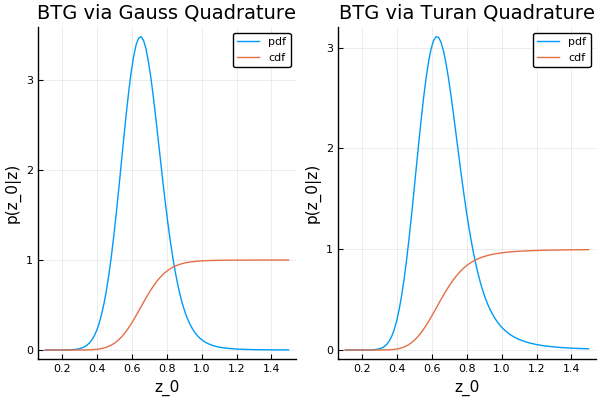

In [11]:
pyplot()

(f, g) = getBtgDensity(train, test, range_theta, range_lambda, boxCoxObj, "Gaussian", "Uniform")
(xG, yG) = plt_data(f, 0.1, 1.5, 100) 
(aG, bG) = plt_data(g, 0.1, 1.5, 100)
Xs = hcat(xG, aG); Ys = hcat(yG, bG)
plt1 = Plots.plot(Xs, Ys, labels = ["pdf" "cdf"], title = "BTG via Gauss Quadrature", xlabel = "z_0", ylabel = "p(z_0|z)")

(f1, g1) = getBtgDensity(train, test, range_theta, range_lambda, boxCoxObj, "Turan", "Uniform")
(xT, yT) = plt_data(f1, 0.1, 1.5, 100) 
(aT, bT) = plt_data(g1, 0.1, 1.5, 100)
Xs1 = hcat(xT, aT); Ys1 = hcat(yT, bT)
plt2 = Plots.plot(Xs1, Ys1, labels = ["pdf" "cdf"], title = "BTG via Turan Quadrature", xlabel = "z_0", ylabel = "p(z_0|z)")

Plots.plot(plt1, plt2, layout = 2) 

## 3) Cross-Validation
In this section we do delete-one cross validation on the first thirty datapoints in the Abalone dataset. It remains to compute MSE and other loss metrics.

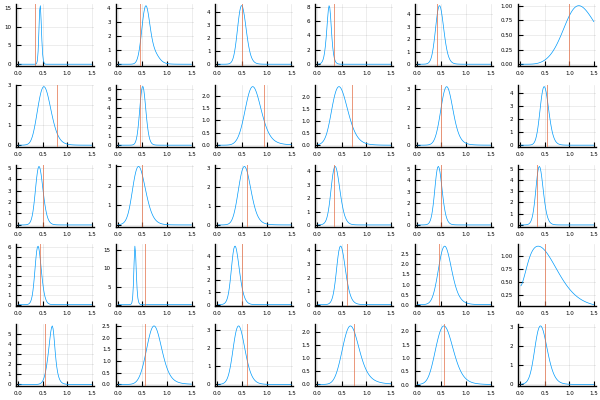

findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


In [12]:
Xs, Ys = cross_validate(train, range_theta, range_lambda, boxCoxObj, "Gaussian", "Uniform")  
z = train.z
plt1 = Plots.plot(Xs, Ys, 
layout = length(z), 
legend=nothing, 
xtickfont = Plots.font(4, "Courier"),
ytickfont = Plots.font(4, "Courier"), 
lw=0.5)

Plots.plot!(z', layout = length(z), 
legend=nothing, 
seriestype = :vline, 
xtickfont = Plots.font(4, "Courier"), 
ytickfont = Plots.font(4, "Courier"), 
lw=0.5)

# 4) Statistics
In this section, we compute median, mode and credible interval using the pdf, cdf 

In [6]:
include("../src/statistics.jl")

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1273


credible_interval (generic function with 3 methods)

In [13]:
# the predicted value in [0, 1] domain
# Using Gauss Quadrature
pval = .4 # compute .4 for example
quant = quantile(f, g;p=pval)
med = median(f, g)
mod = mode(f, g)
CI_equal = credible_interval(f, g, mode=:equal)
CI_narrow = credible_interval(f, g, mode=:narrow)
println("Using Gauss Quadrature,")
println("$pval quantile = $quant")
println("$median = $med \nmode = $mod")
println("symmetric credible interval = [$(CI_equal[1]),$(CI_equal[2])]")
println("narrowest credible interval = [$(CI_narrow[1]),$(CI_narrow[2])]\n")

# Using Turan Quadrature
quant1 = quantile(f1, g1;p=pval)
med1 = median(f1, g1)
mod1 = mode(f1, g1)
CI_equal1 = credible_interval(f1, g1, mode=:equal)
CI_narrow1 = credible_interval(f1, g1, mode=:narrow)
println("Using Turan Quadrature,")
println("$pval quantile = $quant1")
println("median = $med1 \nmode = $mod1")
println("symmetric credible interval = [$(CI_equal1[1]),$(CI_equal1[2])]")
println("narrowest credible interval = [$(CI_narrow1[1]),$(CI_narrow1[2])]")

Using Gauss Quadrature,
0.4 quantile = 0.6282430460493835
median = 0.6570905244655909 
mode = 0.6485619857403951
symmetric credible interval = [0.4421561124151756,0.9246706253465935]
narrowest credible interval = [0.42742235142502366,0.9053212446456742]

Using Turan Quadrature,
0.4 quantile = 0.6185444317175302
median = 0.6508203506203487 
mode = 0.6281705909728237
symmetric credible interval = [0.431303699949184,1.0583994649546768]
narrowest credible interval = [0.3939645948354055,0.9787472454347104]


## scale back to real label value

In [14]:
# scale pdf and cdf accordingly
gg(x) = g(x/zmax)
ff(x) = f(x/zmax)/zmax 
gg1(x) = g1(x/zmax)
ff1(x) = f1(x/zmax)/zmax 

ff1 (generic function with 1 method)

In [15]:
# Using Gauss Quadrature
quant_real = zmax * quant
med_real = zmax * med
mod_real = zmax * mod
CI_equal_real = zmax .* CI_equal
CI_narrow_real =  zmax .* CI_narrow
println("Scale back to real label value:\n")
println("Using Gauss Quadrature,")
println("$pval quantile = $quant_real")
println("median = $med_real \nmode = $mod_real")
println("symmetric credible interval = [$(CI_equal_real[1]),$(CI_equal_real[2])]")
println("narrowest credible interval = [$(CI_narrow_real[1]),$(CI_narrow_real[2])]\n")

quant_real1 = zmax * quant1
med_real1 = zmax * med1
mod_real1 = zmax * mod1
CI_equal_real1 = zmax .* CI_equal1
CI_narrow_real1 =  zmax .* CI_narrow1
println("Using Gauss Quadrature,")
println("$pval quantile = $quant_real1")
println("median = $med_real1 \nmode = $mod_real1")
println("symmetric credible interval = [$(CI_equal_real1[1]),$(CI_equal_real1[2])]")
println("narrowest credible interval = [$(CI_narrow_real[1]),$(CI_narrow_real[2])]")

Scale back to real label value:

Using Gauss Quadrature,
0.4 quantile = 12.56486092098767
median = 13.141810489311819 
mode = 12.971239714807902
symmetric credible interval = [8.843122248303512,18.493412506931868]
narrowest credible interval = [8.548447028500473,18.106424892913484]

Using Gauss Quadrature,
0.4 quantile = 12.370888634350603
median = 13.016407012406974 
mode = 12.563411819456473
symmetric credible interval = [8.62607399898368,21.167989299093538]
narrowest credible interval = [8.548447028500473,18.106424892913484]


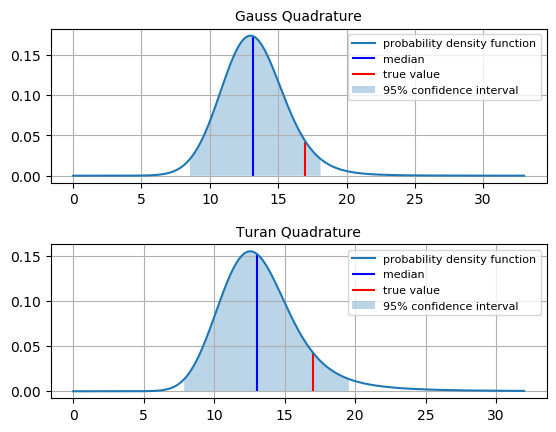

PyObject Text(0.5, 1, 'Turan Quadrature')

In [16]:
# plot 
z0_true = target[i]
fig, axs = PyPlot.subplots(2)
PyPlot.subplots_adjust(hspace=0.4, wspace=0.2)
PyPlot.sca(axs[1])
plt1 = plot_distribution_single(ff, med_real, mod_real, CI_narrow_real, z0_true, "Gauss Quadrature")
PyPlot.sca(axs[2])
plt2 = plot_distribution_single(ff1, med_real1, mod_real1, CI_narrow_real1, z0_true, "Turan Quadrature")